# Videos and Exercises for Session 12: Model Selection and Cross-Validation

In this combined teaching module and exercise set, we will investigate how to optimize the choice of hyperparameters using model validation and cross validation. As an aside, we will see how to build machine learning models using a formalized pipeline from preprocessed (i.e. tidy) data to a model.

The structure of this notebook is as follows:
1. Model Building with Pipelines
2. Model Selection and Validation
    - Simple Validation
    - Cross Validation
    - Tools for Model Selection

## Packages
First, we need to import our standard stuff. Notice that (similar to last session), we are not interested in seeing the convergence warning in scikit-learn, so we suppress them for now.

In [1]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns

# Part 1: Model Building with Pipelines

A powerful tool for making and applying models are pipelines, which allows to combine different preprocessing and model procedures into one. This has many advantages, mainly being more safe but also has the added side effect being more code-efficient.

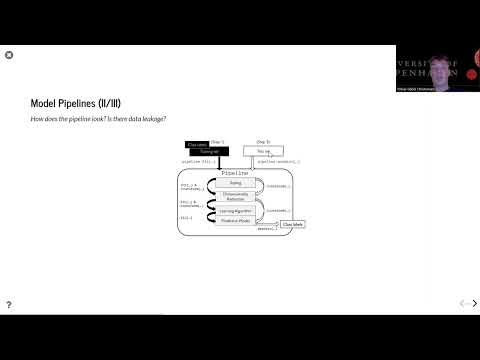

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo('e_98Co2xRuQ', width=640, height=360)


First, load the housing dataset from Ex. 11.2.0 using the code below. 

In [3]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

cal_house = fetch_california_housing()    
X = pd.DataFrame(data=cal_house['data'], 
                 columns=cal_house['feature_names'])\
             .iloc[:,:-2]
y = cal_house['target']

> **Ex. 12.1.1:** Construct a model building pipeline which: 
> 1. adds polynomial features of degree 3 without bias;
> 2. scales the features to mean zero and unit std. 

> *Hint:* a modelling pipeline can be constructed with `make_pipeline` from `sklearn.pipeline`.

In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression

pipe_lr = make_pipeline(PolynomialFeatures(degree=3, include_bias=False),
                            StandardScaler(),
                            LinearRegression())

# Part 2: Model Selection and Validation


## Simple Validation
In machine learning, we have two types of parameters: those that are learned from
the training data, for example, the weights in logistic regression, and the parameters
of a learning algorithm that are optimized separately. The latter are the tuning
parameters, also called *hyperparameters*, of a model. These could for example be the regularization
parameter in logistic regression or the depth parameter of a decision tree.

Below, we investigate how we can choose optimal hyperparameters.

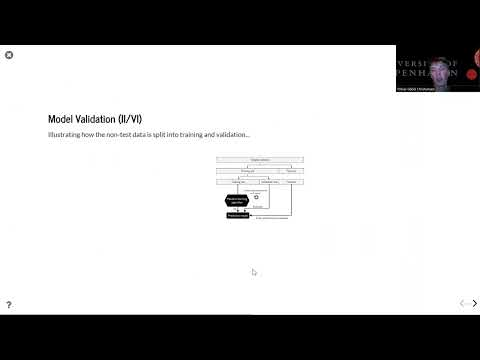

In [9]:
YouTubeVideo('jSPGLkxJ0cQ', width=640, height=360)

In what follows, we will regard the "train" (aka. development, non-test) data for two purposes. 
- First we are interested in getting a credible measure of models under different hyperparameters to perform a model selection. 
- Then - with the selected model - we estimate/train it on all the training data. 

> **Ex. 12.2.1:** Make a for loop with 10 iterations where you:
> 1. Split the input data into, train (also know as development) and test where the test sample should be one third. Set a new random state for each iteration of the loop, so each iteration makes a different split.
> 2. Further split the training (aka development) data into two even sized bins; the first data is for training models and the other is for validating them. Therefore these data sets are often called training and validation.
> 3. Train a linear regression model with sub-training data. Compute the RMSE for out-of-sample predictions for both the test data  and the validation data. Save the RMSE.
>
> You should now have a 10x2 DataFrame with 10 RMSE from both the test data set and the train data set. Compute descriptive statistics of RMSE for the out-of-sample predictions on test and validation data. Are they simular?    
>   They hopefuly are pretty simular. This shows us, that we can split the train data, and use this to fit the model. 
>
> *Hint*: you can reuse any code used to solve e.g. exercises 11.3.2.

In [13]:
from sklearn.metrics import mean_squared_error as mse

perform = []
for n in range(10):
    X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=n*1000)
    X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=n*1000)
    
    pipe_lr.fit(X_train, y_train)
    y_val_pred = pipe_lr.predict(X_val)
    y_test_pred = pipe_lr.predict(X_test)

    perform.append([np.sqrt(mse(y_val_pred, y_val)), np.sqrt(mse(y_test_pred, y_test))])

df_perform = pd.DataFrame(perform, columns=['Validation', 'Testing'])
df_perform.describe().round(3)

,Validation,Testing
count,10.000,10.000
mean,291.635,383.514
std,529.688,764.628
min,1.012,2.368
25%,69.642,4.349
50%,121.316,23.628
75%,219.568,110.079
max,1774.129,2207.861


> **Ex. 12.2.2:** Construct a model building pipeline which 
> 1. adds polynomial features of degree 3 without bias;
> 2. scales the features to mean zero and unit std. 
> 3. estimates a Lasso model

In [14]:
from sklearn.linear_model import Lasso

pipe_lasso = pipe_lasso = make_pipeline(PolynomialFeatures(degree=3, include_bias=False), 
                               StandardScaler(),
                               Lasso())

## Cross Validation

  
The simple validation procedure that we outlined above has one disadvantage: it only uses parts of the *development* data for validation. In the video below, we present a refined approach that uses all the *development* for validation.



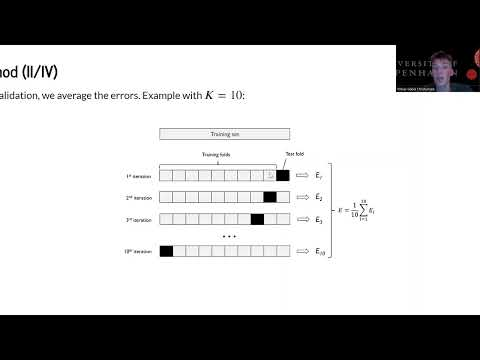

In [3]:
YouTubeVideo('-G--B3woZGU', width=640, height=360)

When we want to optimize over both normal parameters and hyperparameters, we do this using nested loops (two-layered cross validation). In the outer loop, we vary the hyperparameters, and then in the inner loop, we do cross validation for the model with the specific selection of hyperparameters. This way, we can find the model with the lowest mean MSE. 

> **Ex. 12.2.3:**
Run a Lasso regression using the Pipeline from `Ex 12.2.2`. In the outer loop, search through the lambdas specified below. 
In the inner loop, make *5 fold cross validation* on the selected model and store the average MSE for each fold. Which lambda, from the selection below, gives the lowest test MSE?
>  ```python 
> lambdas =  np.logspace(-4, 4, 12)
> ```
> *Hint:* `KFold` in `sklearn.model_selection` may be useful.

In [30]:
from sklearn.model_selection import KFold
kfolds = KFold(n_splits=5)
folds = list(kfolds.split(X_dev, y_dev))

mseCV = []
lambdas = np.logspace(-4, 4, 12)
if type(X_dev) != np.ndarray:
    X_dev = X_dev.values

for lamb in lambdas:
    mseCV_ = []
    for train_idx, val_idx in folds:
        
        pipe_lassoCV = make_pipeline(PolynomialFeatures(degree=3, include_bias=False),
                                     StandardScaler(),
                                     Lasso(alpha=lamb))            
        X_train, y_train = X_dev[train_idx], y_dev[train_idx]
        X_val, y_val = X_dev[val_idx], y_dev[val_idx] 
        pipe_lassoCV.fit(X_train, y_train)        
        mseCV_.append(mse(pipe_lassoCV.predict(X_val), y_val))    
        
    # Store result    
    mseCV.append(mseCV_) 
    
# Convert to DataFrame
lambdaCV = pd.DataFrame(mseCV, index=lambdas)
ex12_2_3 = lambdaCV.mean(axis=1).nsmallest(1)
print(ex12_2_3)

0.081113    0.664135
dtype: float64


## Tools for model selection

Below we review three useful tools for performing model selection. The first tool, the learning curve, can be used to assess whether there is over- and underfitting.

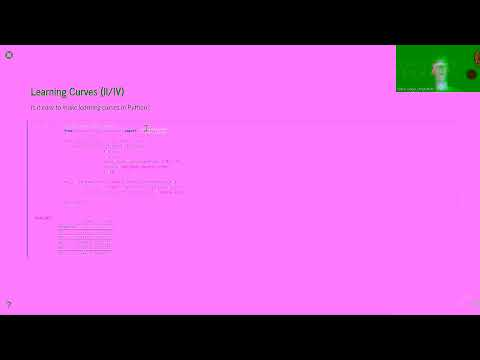

In [23]:
YouTubeVideo('BMR6O9NaYdc', width=640, height=360)

The next tool, the validation curve, helps to make perform automated model selection and to visualize the process of model selection.

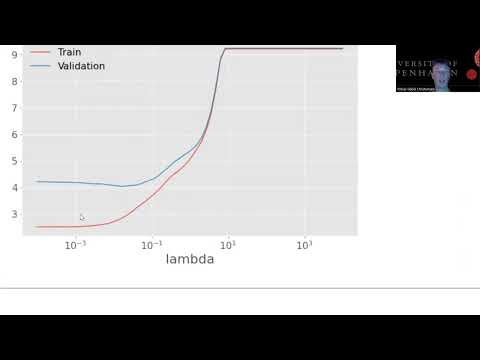

In [24]:
YouTubeVideo('c9NkJC7EzPg', width=640, height=360)

When we have more than one hyperparameter, we need to find the combination of optimal hyperparameters. In the video below we see how to do that for *elastic net*, which has both L1 and L2 regularization.

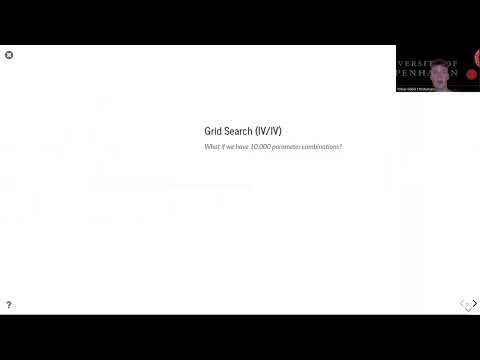

In [25]:
YouTubeVideo('AjEpa24mFGw', width=640, height=360)

> **Ex. 12.2.4:** __Automated Cross Validation in one dimension__  
Now we want to repeat exercise 12.2.3 in a more automated fashion. 
When you are doing cross validation with one hyperparameter, you can automate the process by using `validation_curve` from `sklearn.model_selection`. Use this function to search through the values of lambdas, and find the value of lambda, which give the lowest test error.  
>
> Check if you got the same output for the manual implementation (Ex. 12.2.3) and the automated implementation (Ex. 12.2.4) 
>
> BONUS: Plot the average MSE-test and MSE-train against the different values of lambda. (*Hint*: Use logarithmic axes, and lambda as index)

Manual implementation: 0.081113    0.664135
dtype: float64
Automatic implementation: lambda
0.081113    0.665618
Name: Validation, dtype: float64


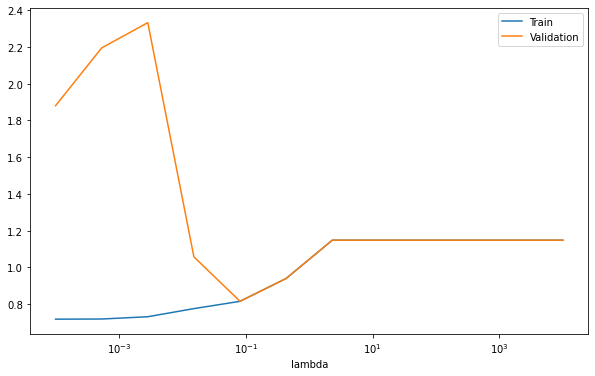

In [50]:
from sklearn.model_selection import validation_curve

train_scores, test_scores = \
    validation_curve(estimator=pipe_lasso,
                     X=X_dev,
                     y=y_dev,
                     param_name='lasso__alpha', #built-in name of hyperparameter
                     param_range=lambdas, #values to consider
                     scoring='neg_mean_squared_error',                 
                     cv=5)

mse_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'lambda':lambdas})\
              .set_index('lambda')   
ex12_2_4 = mse_score.Validation.nsmallest(1)

print('Manual implementation:', ex12_2_3)
print('Automatic implementation:', ex12_2_4)

np.sqrt(mse_score).plot(logx=True, figsize=(10,6));

When you have *more than one* hyperparameter, you will want to fit the model to all the possible combinations of hyperparameters. This is done in an approch called `Grid Search`, which is implementet in `sklearn.model_selection` as `GridSearchCV`

> **Ex. 12.2.5:** To get to know `Grid Search`, we want to implement it in one dimension. Using `GridSearchCV`, implement the Lasso, with the same lambdas as before (`lambdas =  np.logspace(-4, 4, 12)`), 10-fold CV and (negative) mean squared error as the scoring variable. Which value of Lambda gives the lowest test error? 

In [57]:
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(estimator=pipe_lasso,
                  param_grid={'lasso__alpha':lambdas},
                  scoring='neg_mean_squared_error',
                  cv=10)

gs.fit(X_dev, y_dev)
gs.best_params_

{'lasso__alpha': 0.08111308307896872}

> **Ex. 12.1.6 BONUS** Now set `lambdas =  np.logspace(-4, 4, 100)`, and repeat the previous now with RandomizedSearchCV with `n_iter=12`.

In [58]:
from sklearn.model_selection import RandomizedSearchCV

lambdas = np.logspace(-4, 4, 100)

rs = RandomizedSearchCV(estimator=pipe_lasso,
                        param_distributions={'lasso__alpha': lambdas},
                        n_iter=12,
                        scoring='neg_mean_squared_error',
                        cv=10)

rs.fit(X_dev, y_dev)
rs.best_params_

{'lasso__alpha': 0.04641588833612782}